   # Analysis of NFκB regulatory module model using MinimallyDisruptiveCurves.jl
   ## Dhruva V. Raman 
   #### (github: Dhruva2, email: dvr23@cam.ac.uk)

### Introduction
- This classic model is constructed in:
**Lipniacki, Tomasz, et al. "Mathematical model of NF-κB regulatory module." Journal of theoretical biology 228.2 (2004): 195-215.**

- It models the dynamics of the intracellular NFκB regulatory module in response to a time-course of the extracellular cytokine TNF (tumour necrosis factor). 

Schematic of the reaction network:
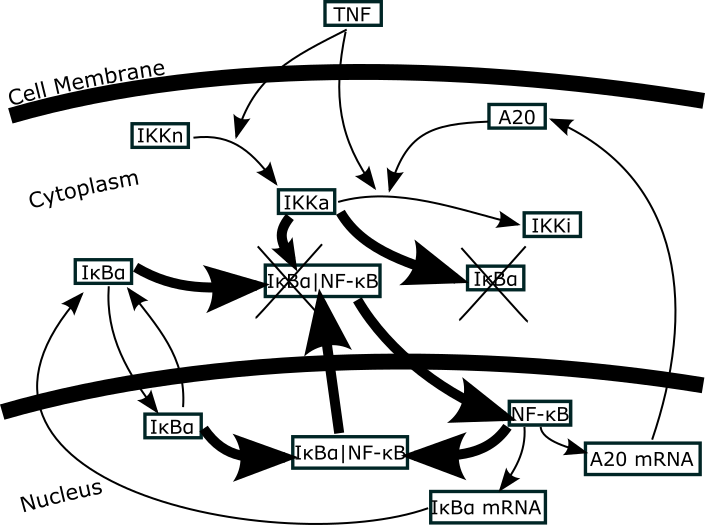

- crosses denote inhibitory effects
- thick arrows are fast timescale reactions, according to the paper




### What is done in this notebook

#### 1. Load NFκB model, and NFκB output map. 
- The ODE model is of the form: $\dot{x} = f(x, p, u, t)$, and the output map is of the form $y = g(x)$. 
- $p$ are the parameters. $p_0$ are the initial (best-fit) parameters. $t$ is time.
- $u(t)$ is an autonomous input representing the time course of TNF influx. We took $u = heaviside(3600 seconds)$ as in the paper. You can choose different, or multiple, input time-courses, if you prefer.

#### 2. Build a loss function `lossf1` of the form:

$$ C(p) = \int^T_0 \| y(p,t) - y(p_0,t)\|_2^2.$$
- We used `DiffEqParamEstim.build_loss_objective` to make this with little effort.
- We use `DiffEqSensitivity.second_order_sensitivities()` to find the hessian $ H = \nabla^2 C(p_0) $. *This took 115 seconds on my laptop, but only needs to be done once*.
- Why the single Hessian? Since $\nabla C(p_0) = 0$ (local minimimum), we use the Hessian to find initial MDC directions that don't greatly disrupt the cost function $C$, to second order.


#### 3. Generate initial curve directions for the minimally disruptive curves
by solving the nonconvex, quadratically constrained quadratic program:

$$ \min_x x^T H x + \lambda \| x \|_1 : \quad x^Tx = 1,$$ 
where $H$ is the hessian, and $\lambda = 1$ is a regularisation hyperparameter.
- This uses a simple approx 20 line function `sparse_init_dir` included in helper_functions.jl. 
- We set $\lambda = 1.$. This $\mathcal{L}_1$ regularisation term enforces sparsity, so the initial curve directions only involve a few parameters at a time.
- This is **nonconvex**, with multiple local solutions. By randomising the initial conditions of the optimisation, we get many different solutions corresponding to different promising initial curve directions. 
- We removed duplicate solutions and selected the 5 best directions

#### 4. Generate 5 minimally disruptive curves corresponding to each of the 5 best initial curve directions.
- You can run the nth curve yourself by reassigning `which_dir = n`. 
- The longest curves took 410 seconds on my laptop. Most took 100-200 seconds.
- You could generate curve 6, 7, etc...there are about 20 potential directions.



#### 5. **Scientific analysis of the curves is provided at the bottom of the notebook**. 
- But note that I'm not a domain expert on this system :)


## The code

In [ ]:
using MyModelMenagerie, OrdinaryDiffEq, MinimallyDisruptiveCurves, Plots, DiffEqParamEstim, DiffEqSensitivity, LinearAlgebra

In [ ]:
include("helper_functions.jl");
alg = Vern7 #or eg Tsit5, used for solving ODE
solve = OrdinaryDiffEq.solve; #because it clashes with JuMP.solve

In [ ]:
od,ic,tspan,ps = NFKBModel(soft_heaviside(0.01,3600)); #argument is input to the model

- Below, we fix the parameters that are clearly non-disruptive just from inspection of the equations: they only affect system states which do not interact with or affect the output. 
- We also transform the parameters and cost functions by using the log_abs_transform:
$$ \phi(p) = log(abs(p))$$
$$ \tilde{C}(\phi(p)) = C(\phi(p)) $$.
- This prevents sign changes, and allows us to consider relative changes in the parameters, i.e. we bypass the issue that the nominal parameter values span several orders of magnitude.

In [ ]:
prob = ODEProblem(od,ic,tspan,ps)
to_fix = ["c2c","c2","c2a","c3c", "c1c", "a2"]
tstrct_fix = fix_params(last.(ps), get_name_ids(ps, to_fix))
od, ic, ps = transform_problem(prob,tstrct_fix; unames = first.(ic), pnames = first.(ps))
prob = ODEProblem(od,ic,tspan,ps)
tstrct_log = logabs_transform(last.(ps))
od, ic, ps = transform_problem(prob, tstrct_log; unames=first.(ic), pnames = first.(ps))
prob = ODEProblem(od,ic,tspan,ps);
p0 = last.(ps);

- below, we make a loss function on the solution. It is the l2 norm deviation of the output map of the model simulation, vs the nominal simulation at p0

In [16]:
om = NFKB_output_map
nom_sol = solve(prob, alg())
tsteps = nom_sol.t
integrand(el1, el2) = sum(abs2, om(el1) - om(el2))
lossf(sol, nom_sol) = sum( integrand(el1,el2) for (el1,el2) in zip(eachcol(sol), eachcol(nom_sol)  )  )
lossf1(sol) = lossf(sol, nom_sol);

- below, we get the Hessian at p0 (the one time we must expensively calculate the Hessian). Takes 83 seconds on my laptop. Most of that is probably compiling Julia functions, rather than running the actual code, to be fair.

In [ ]:
nom_prob = ODEProblem(od,ic,tspan,ps) # oop for second_order_sensitivities
@time hess = second_order_sensitivities(lossf1, nom_prob,alg())
cost = build_loss_objective(nom_prob,alg(), saveat = tsteps, lossf1;mpg_autodiff=true);

Below we generate potential directions by solving the QCQP defined in the introduction, 100 times. Random initialisation of the initial guess means that each solution is different. We then prune duplicats and order the solutions in terms of how good they are

In [ ]:
potential_dirs = [sparse_init_dir(hess)[1] for i = 1:100]
pd_projs = [el'*hess*el for el in potential_dirs]; # ie how good is each guess
inds = sortperm(pd_projs) # sort in order
potential_dirs = potential_dirs[inds];

In [19]:
duplicates = [] # remove potential_directions that are approximately equal (norm(a-b) < 1e-5) to previous directions
for (i,el) in enumerate(potential_dirs)
    for (j,comp) in enumerate(potential_dirs[i+1:end])
        if ((norm(el - comp) < 1e-5) || (norm(el + comp) < 1e-5))
            push!(duplicates, i+j)
        end
    end  
end
potential_dirs[unique(duplicates)]
potential_dirs = potential_dirs[setdiff(1:length(potential_dirs), duplicates)];

In [24]:
which_dir = 1;
spans = [(-9., 9.), (-14., 9.), (-19., 19.), (-19., 2.5), (-5., 5.)
]
moms = 10*[1., 1., 1., 1., 1.];

In [25]:
dp0 = potential_dirs[which_dir]
mom = moms[which_dir] 
span = spans[which_dir]
eprob = MDCProblem(cost, p0, dp0, mom, span);

In [ ]:
@time mdc = evolve(eprob, Tsit5);

In [12]:
# savefig(p, "NFKB_mdc_$(which_dir).png")

# Analysing the Minimally Disruptive Curve outputs

- You can generate the nth curve yourself by running the code above, and setting which_dir = n. 
- Here I generate and analyse the first 5 curves.
- Note that in each curve, **all** parameters of the model are free to vary. I used the purely automatic initial direction selection given in the code above. So generation of the curves required no domain knowledge.
- However, I only graphed the 5 biggest changing parameters (over the curve), to avoid cluttering the figures.
- In general, domain knowledge might be used to infer free parameters and promising initial curve directions.

**Note**: I didn't graph the dynamics of the perturbed NFkB model as parameters varied along the MD curves in general. If you want to do this, run the block of code below. Substitute 
```s = (distance along mdc curve you want to test).```

**Note**: to give you a rough idea of how much 'cost = x' visually perturbs the dynamics, I plotted an example below, where the cost = 0.49 (higher than any point on any minimally disruptive curve in this notebook!). This was on the 5th MDC, where I set the final distances higher than in this notebook. Note that the cost is on the **output trajectory**, not the state trajectory. So the latter changes a bit more, as you can see.

**Conclusion:** the cost is negligibly small at any point on the following minimally disruptive curves.

In [ ]:
using Printf
s = 6.
ss = check_sol_at_dist(s,prob, mdc)
sol = solve(prob, alg())
p1 = plot(ss.t,transpose(hcat(om.(ss.u)...)), legend = false, title = "perturbed trajectory: outputs")
annotate!(p1, 40000, 0.3, "cost = $(@sprintf("%.2f", cost(mdc(s)[:states])))")
p2 = plot(sol.t,transpose(hcat(om.(sol.u)...)), legend = false, title = "nominal trajectory: outputs")
p3 = plot(ss, legend=false, title = "perturbed trajectory: all states")
p4 = plot(sol, legend=false, title = "nominal trajectory: all states")
pp = plot(p1,p2,p3,p4)
# savefig(pp, "mdc_vs_nominal_nfkb_comparison.png")

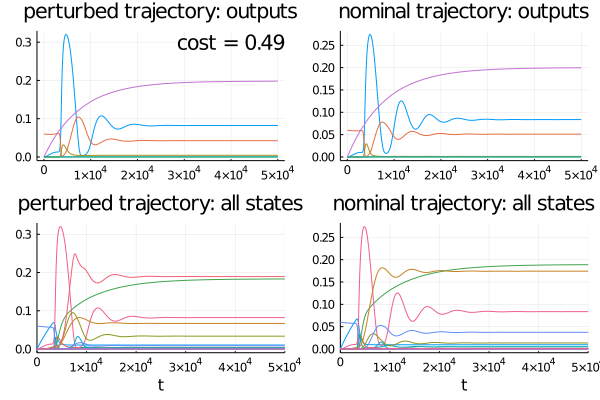

## Curve 1
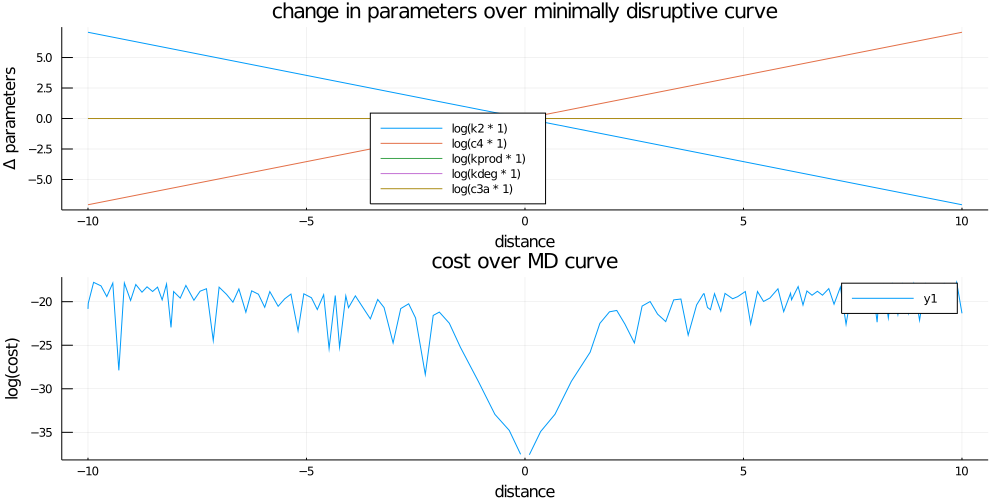

#### Mathematical points
- The first MDC uncovers a structural unidentifiability in the model: model output is completely invariant to changes that preserve $log(k_2) + log(c_4)$, i.e. the product $k_2c_4$. 
- 'Completely' is numerical, obviously, but cost < 1e-18 is pretty close to zero.
- An algebraic method of uncovering this particular unidentifiability, in the same model, is provided in:
**Villaverde, Alejandro F., Antonio Barreiro, and Antonis Papachristodoulou. "Structural identifiability of dynamic systems biology models." PLoS computational biology 12.10 (2016): e1005153.**

#### Interpretation
- Look at the reaction network diagram at the top of the notebook: 
$c_4$ determines the transcription rate of $A20$, while $k_2$ determines the efficacy of $A20$ in encouraging the inactivation of $IKK$. 
- So the MDC makes sense: halving production of A20, while doubling its effect on the reaction it takes part in, doesn't alter observed dynamics.


## Curve 2
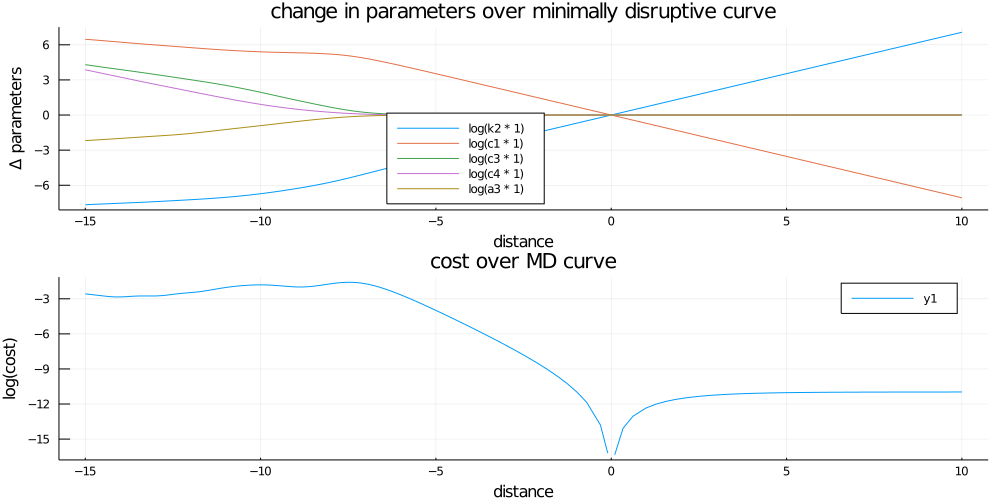

#### Mathematically
- If we increase $k_2$, but decrease $c_1$ proportionally (ie preserving $k_2c_1$), nothing happens to model behaviour.
- If we decrease $k_2$ but increase $c_1$ proportionally in the same manner: initially dynamics are preserved, but eventually they start to get perturbed. Increases in $c_3$ and $c_4$, and a decrease in $a_3$, mitigate this.

#### Scientifically
- $c_1$ is the rate of production of $A20t$ (A20 transcript) from nuclear NFkB. There is also a constitutive production rate $c_2$.
- $k_2$ determines the efficacy of $A20$ in encouraging the inactivation of $IKK$. 

So the curve shows that we can decrease the production rate of $A20$ transcript from $NFKBn$ indefinitely, as long as we correspondingly increase the efficacy of $A20$ in inactivating $A20$. 

On the other hand, if we **increase** the production rate of $A20$ transcript, and correspondingly **decrease** the $A20$ efficacy, an effect on dynamics is eventually felt. This is compensated by 
- Decreasing $a_3$, the rate of conglomeration of activated IKK (IKKa) with IkBaNFkB complex. IE reducing the reactive power of the IKKa, whose concentration is being increased by the larger amount of $A20$

- Increasing $c_4$ and $c_3$. The first **increases** the production rate of $A20$ from $A20t$. However the second **decreases** the amount of $A20t$ by increasing degradation rate. 

## Curve 3
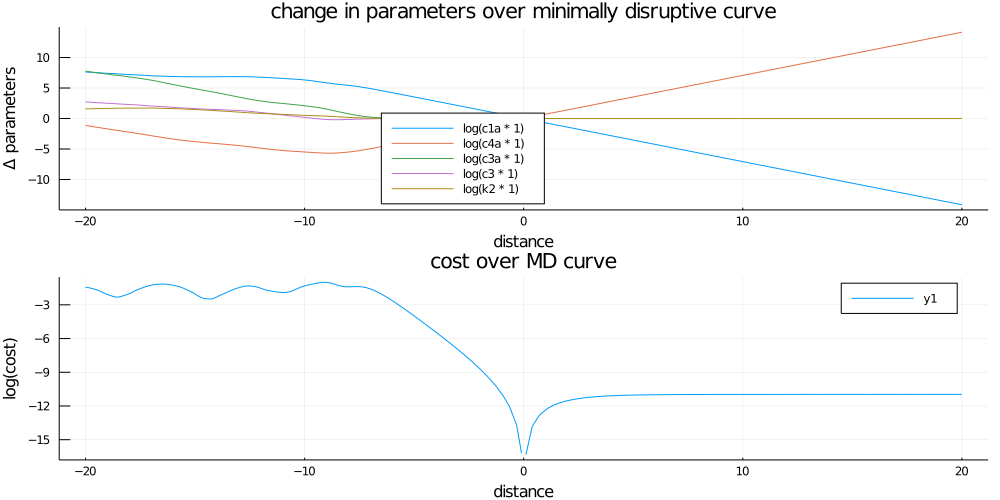

#### Interpretation

- If we increase $c1a$, and decrease $c4a$ proportionately, so that the product $log(c1a) + log(c4a)$ is preserved, there is almost no effect on dynamics.

- $c1a$ is the rate of production of IkBa transcript from NFkBn. $c4a$ is the translation rate of IkBa transcript. So this makes sense: more transcript, but less translation from the transcript, equals about the same amount of IkBa.

- However, this MD curve breaks down if we instead **increase** $c1a$ and decrease $c4a$ proportionately. So more transcript production, but less translation from the transcript. This is likely caused by the difference in time constants for the two reactions. Iti s compensated in this MD Curve by increasing $c3a$, the degradation rate of the transcript.

## Curve 4
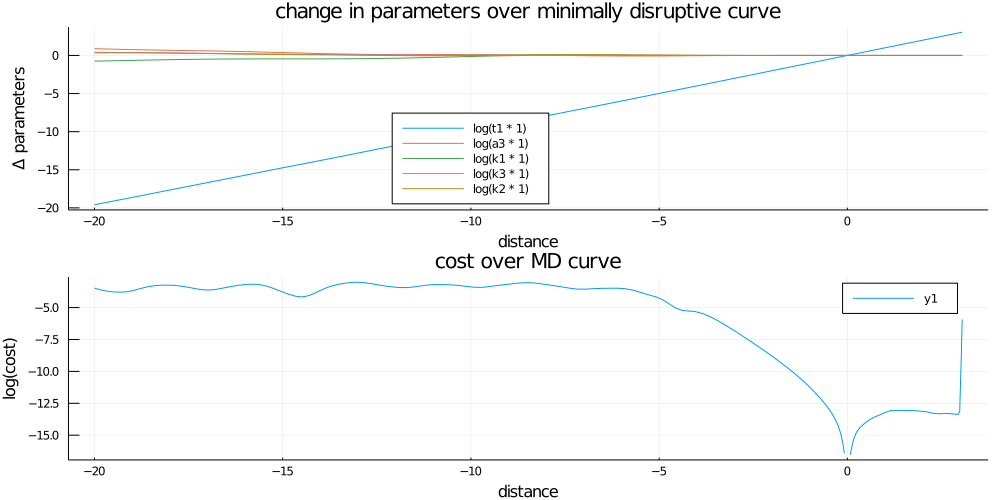

#### Interpretation

- $t1$ is the dissociation rate of $IKKa$ from the $IKKaIkBa$ complex. It's described as a fast timescale reaction in the original modelling paper.
- It can be slowed by 20 orders of magnitude without altering observed behaviour, apparently.
- It can also be increased indefinitely. However, if it increases too much, numerical problems hit the ODE solver, as you can see at the end of the curve. Probably this is because the dynamics become stiff, as the timescale of the $t1$ reaction is so fast relative to the rest of the system. 
- I manually double-checked with a stiff ODE solver that increasing $t1$ further doesn't affect dynamics. 

This suggests that you could assume instant equilibration of the $t1$ reaction to simplify the model, without affecting dynamics.

## Curve 5
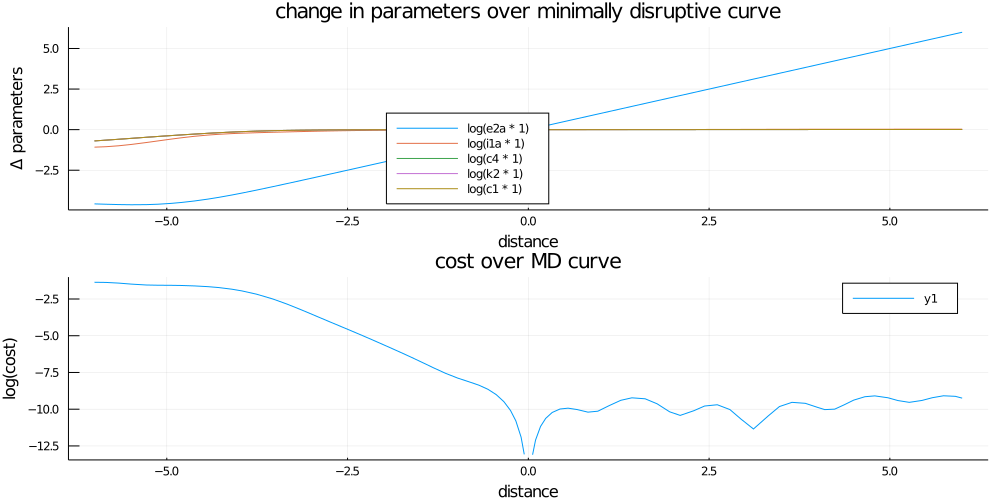

#### Interpretation

- $e2a$ is the transport rate of IkBaNfKbn from the nucleus to the cytoplasm.
- $e2a$ is described as a fast timescale reaction in the original modelling paper. Increasing it further doesn't change dynamics.
- This suggests that you could assume instant equilibration of the $e2a$ reaction to simplify the model, without affecting dynamics.
- This suggests that intrinsic variability in this transport rate wouldn't affect functionality of the regulratory module.